# Sea Level and Flood Frequency Counts

_Jim P_

_September 2023_

This notebook gives an example of accessing tide gauge data from the University of Hawaii Sea Level Center (UHSCL, https://uhslc.soest.hawaii.edu) and doing some different analyses.  The code was contributed by Aesha Genz and modified by Jim Potemra.

----

The notebook will create four figures:
 1. the raw tide gauge record
 2. the monthly mean data along with monthly anomalies
 3. a trend fit
 4. a bar chart showing the flood frequency
 
 For example, the plots for the Malakal gauge look something like this:
 
 <img src='Malakal_raw.png'>
 <img src='Malakal_anom.png'>
 <img src='Malakal_trend.png'>
 <img src='Malakal_freq.png'>

## Load the necessary python packages

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# Get the data
There are several ways to get tide gauge data from the UHSLC.  This includes raw download via FTP, OPeNDAP services and via ERDDAP.  The UHSLC also provides different types of data, _e.g._ , research quality (has gone through rigorous QA/QC, but delayed in time) and "fast delivery" (real-time, but no QC).  Finally, the UHSLC provides different file types, _e.g._ , netCDF and ASCII.

In this example, we'll try to abstract much of this. Since the UHSLC data servers use a consistant file naming convention, and RESTful services, once we go through one example, it should be straightforward to get data from any tide gauge and repeat the process.

## Define parameters (site, epoch, threshold)
The analysis will be run for a specific tide gauge location (__station__) over a specific time range (__epoch__).  The flood frequency is computing using a threshold value (__threshold__).  These three parameters are all defined below.

In addition, the user can specify whether __daily__ or __hourly__ tide gauge data are used.  Finally, the analysis can be done using the near-real-time data (__fast__) or QC'd, delayed mode data (__rsqd__).

After setting these parameters, the rest of the notebook should run without any changes needed.

In [2]:
# Specifics for this analysis.  

#  1. First we enter the site name.  Note this can be any portion of 
#     the actual station name, in upper or lower case.  So, for example, 
#.    "hon," "honolulu," "Honolulu," "HON" will all resolve (find) to the 
#.    Honolulu gauge.  However, "HNL" will not (for example).
station = 'Mala'

#  2. Second we define the epoch over which we will compute flood frequeny
epoch = [1993,2022]

#  3. Define the threshold for flooding (in cm) from stationary GPD
threshold = 260.9674

#  4. Chose either the fast (fast) delivery data or the delayed-mode
#     research quality data (rqds)
data_form = 'fast'

#  5. Select the time-resolution (hourly or daily)
time_res = 'hourly'

<font color="red">Note: should not have to change anything beyond this point</font>

## Access the UHSLC data catalogue
The UHSLC data listing is at http://uhslc.soest.hawaii.edu and provides a table off all the sites, their lat/lon, ID number and so on.  We will use the UHSLC ERDDAP instance to pull the table into a DataFrame.

The table includes a lot of parameters (_e.g._ , latitude, longitude, _etc_.) but we will only use a subset (defined below as __constraints__.

In [3]:
# Get list of all tide gauge stations by name and station ID
data_site = 'https://uhslc.soest.hawaii.edu/erddap/tabledap/global_' + \
             time_res + '_' + data_form + '.html'

# The end point is in tabledat format, with contraints listed
# at the end of the URL.  Below are the constraints, or variables,
# that will be retrieved from the ERDDAP server (NOTE: there are
# different parameters for the rqds and the fast)
constraints = ['latitude','longitude','station_name',
               'station_country', 'station_country_code',
               'record_id','uhslc_id','gloss_id']

# Now build the URL
specs = '%2C'.join(constraints)
url = data_site + 'Table?' + specs

# scrape the table and put into a list
gauge_sites = pd.read_html(url)

# convert list to DataFrame
# Note:
#  1. For some reason there maybe ne duplicate rows, so I drop these
#  2. We ignore the null first row in the table (so [1])
gauges = gauge_sites[1].drop_duplicates()
gauges.columns = gauges.columns.droplevel(-1)

## Get data for specific site
We now have a table (variable is __gauges__) that has the tide gauge site names, id numbers, country, _etc._  We will use this to pull data.

Since the ERDDAP site is "RESTful" it includes the site number.  We can abstract this by generating the data access end point. First, the desired tide gauge is specified.  We try to find a match based on case-insensitive string match. So, for example, if the actual gauge name is "Honolulu," any/all of the following station names "hono," "Hono," "HONOLULU," etc. should get the data.  However, "HNL" would not, as there is no clear match to "Honolulu."

In [4]:
# Scan through the table with tide gauge names, find the one we want,
# and get the ID number; this will be used to get the data
for ind in gauges.index:
    gauge_name = gauges['station_name'][ind]
    if station.lower() in gauge_name.lower():
        gauge_name = gauges['station_name'][ind]
        gauge_number = str(gauges['uhslc_id'].tolist()[ind]).zfill(3)
        break

In [5]:
print("Station chosen is gauge number", gauge_number, " at ", gauge_name)
print( data_form, 'data at', time_res, 'resolution')

Station chosen is gauge number 007  at  Malakal
fast data at hourly resolution


In [6]:
# Finally, we pull the data from the UHSLC OPeNDAP server
url_root = 'http://uhslc.soest.hawaii.edu/opendap/' + data_form + '/' + time_res + '/'
fname = url_root + "h" + gauge_number + ".nc"
data = xr.open_dataset(fname)

# Just to be sure, we get the station name directly from the file
station_name = data['station_name'].values[0].decode('UTF-8')

## plot data

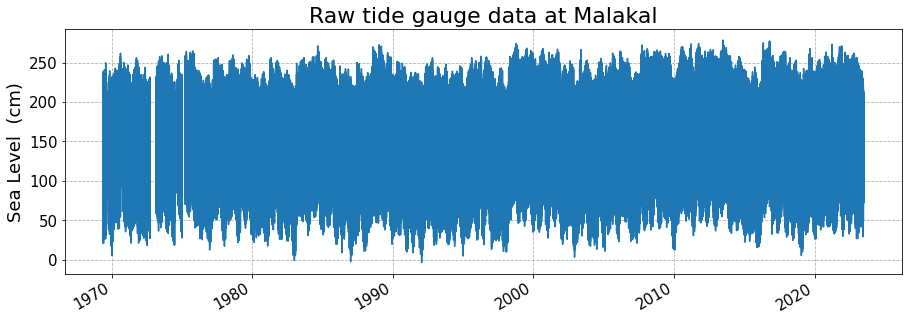

In [7]:
fig, ax = plt.subplots(figsize=[15,5])
fig.autofmt_xdate()
ax.plot(data.time.values,data.sea_level.T.values/10)
ax.grid(linestyle='dashed')
ax.set_ylabel('Sea Level  (cm)',fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Raw tide gauge data at " + station_name, fontsize=22)
plt.savefig(station_name + '_raw.png', facecolor = 'white', format = 'png')

# Compute and plot longterm trend
The data between the two ranges defined in __epoch__ will be converted to monthly means, then monthly anomalies.  A least-squares fit will then be made to the monthly anomalies.

In [8]:
# Subset data between epoch start and end dates
epoch_start = f"{epoch[0]}-01-01"
epoch_end = f"{epoch[-1]}-12-31"

data_epoch = data.sel(dict(time=slice(epoch_start, epoch_end)))
data_epoch['sea_level'] = data_epoch.sea_level/10 #convert mm to cm

In [9]:
# compute monthly means
sl_mmean = data_epoch.sea_level.resample(time='1MS').mean()

# compute monthly anomalies
sl_clim = sl_mmean.groupby('time.month').mean('time')
sl_anom = (sl_mmean.groupby('time.month') - sl_clim)

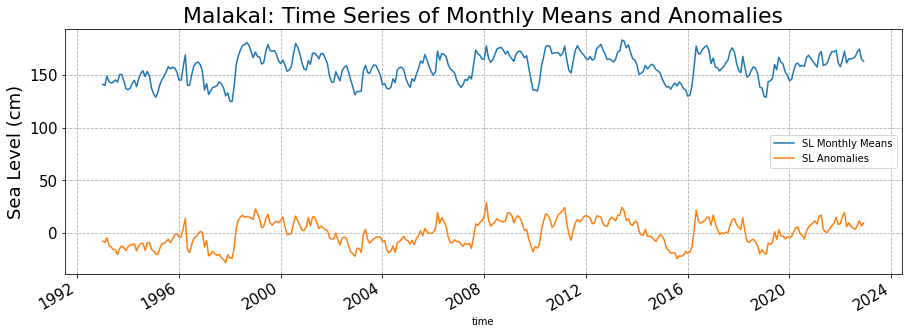

In [10]:
fig, ax = plt.subplots(figsize=[15,5])
fig.autofmt_xdate()
sl_mmean.plot(label = 'SL Monthly Means')
sl_anom.plot(label = 'SL Anomalies')
ax.legend()
ax.set_ylabel('Sea Level (cm)',fontsize=18)
ax.grid(linestyle='dashed')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title( station_name + ': Time Series of Monthly Means and Anomalies',fontsize=22)
plt.savefig(station_name + '_anom.png', facecolor = 'white', format='png')

## Fit a line to the seasonal anomalies

In [11]:
nt = len(sl_anom.T)
time = np.arange(1,nt+1)
B = np.polyfit(time,sl_anom.T,1)
Trendval = B[0] * nt
ssh_trend = np.polyval(B,time)

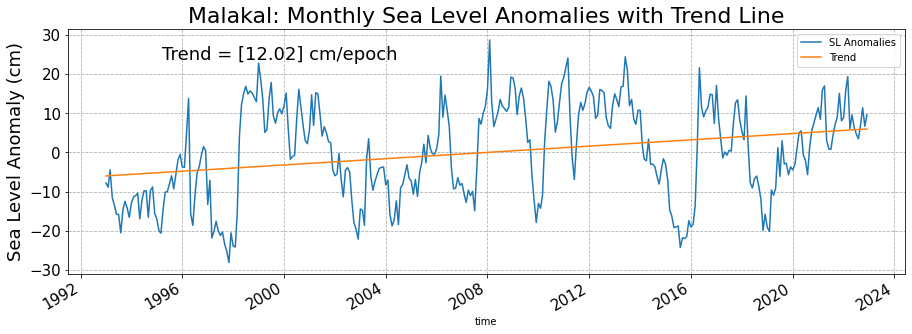

In [12]:
fig, ax = plt.subplots(sharex=True,figsize=[15,5])
fig.autofmt_xdate()
sl_anom.plot(label = 'SL Anomalies')
ax.plot(sl_anom['time'].values,ssh_trend, label = 'Trend')
ax.legend()
ax.grid(linestyle='dashed')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_ylabel('Sea Level Anomaly (cm)',fontsize=18)
plt.title(station_name + ': Monthly Sea Level Anomalies with Trend Line',fontsize=22)
ax.annotate(f'Trend = {np.round(Trendval,3)} cm/epoch',xy=(.15,.8),xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',fontsize=18)
plt.savefig(station_name + '_trend.png', facecolor = 'white', format='png')

# Compute flood frequency
In this part we compute and display the number of times sea level exceeds a certain level.  This calculation is done over the same epoch as defined above.  The display is presented as a bar chart.  The value is computed as the sum number of times in a year when sea level exceeds the threshold value.

## Calculate flood frequency counts

In [13]:
# This complicated line essentially takes sea level (data_epoch['sea_leve'])
# and then looks for when this exceeds threshold between two time ranges
#  .sel(time=slice(epoch_start,epoch_end))
# and sums over a year
#  .resample(time='Y').sum()
freq_count_yr = (data_epoch['sea_level'] >= \
                 threshold).sel(time=slice(epoch_start,epoch_end)).resample(time='Y').sum()

## Plot flood frequency counts as bar chart 

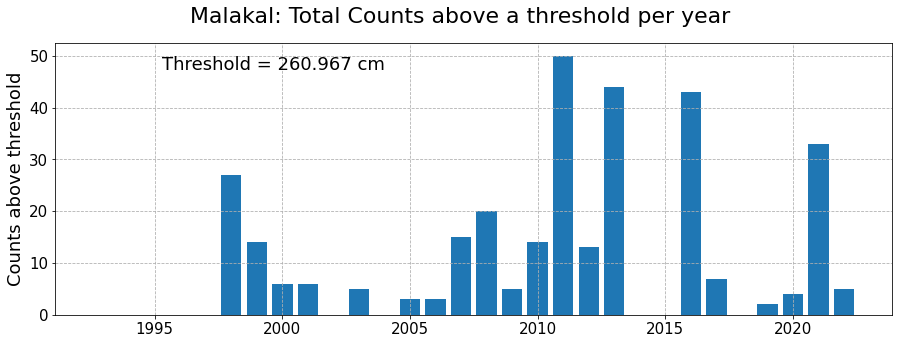

In [14]:
fig, ax = plt.subplots(figsize=[15,5])
yr = np.arange(epoch[0],epoch[-1]+1)
ax.bar(yr,freq_count_yr[0,:])
ax.set_ylabel('Counts above threshold',fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(linestyle='dashed')
fig.suptitle(station_name + ': Total Counts above a threshold per year',fontsize=22)
ax.annotate(f'Threshold = {np.round(threshold,3)} cm',xy=(.15,.8),xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',fontsize=18)
plt.savefig(station_name + '_freq.png', facecolor = 'white', format='png')